# S3VT Landsat and Sentinel 2 validation of hotspots - working

## Description
This notebook demonstrates how to:
 
From a candidate latitude longitude and solar_day:
* determine if intersecting Landsat or Sentinel 2 ARD exists
* apply the platform specific tests to determine if hotspots were detected in the vicinity 5km of hotspot
* return true, false or - for each candidate point
* as a secondary test perform a Normalized Burnt Ratio (at least one month prior)
 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices


In [2]:
# Buffer candidate hotspot with 5 kilometre radius (or .05 degrees will do)
def buffer_hotspot(lon, lat):
    ul_lon = lon - 0.05
    lr_lon = lon + 0.05
    ul_lat = lat + 0.05
    lr_lat = lat - 0.05
    return ((ul_lon, lr_lon), (ul_lat, lr_lat))

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='validating_hotspots')

### Be ignorant of the sensor

In [4]:
sensor_ignorance = {'msi':{'0.433-0.453': 'nbart_band_01',
                           '0.450-0.515': 'nbart_band_02',
                           '0.525-0.600': 'nbart_band_03',
                           '0.630-0.680': 'nbart_band_04',
                           '0.845-0.885': 'nbart_band_08',
                           '1.560-1.660': 'nbart_band_11',
                           '2.100-2.300': 'nbart_band_12'},
                   'oli': {'0.433-0.453': 'nbart_band01',
                           '0.450-0.515': 'nbart_band02',
                           '0.525-0.600': 'nbart_band03',
                           '0.630-0.680': 'nbart_band04',
                           '0.845-0.885': 'nbart_band05',
                           '1.560-1.660': 'nbart_band06',
                           '2.100-2.300': 'nbart_band07'}}

In [5]:
# arguments
hotspot_lon = 150.8
hotspot_lat = -32.65
hotspot_solar_day = "2019-12-31"
sensors_products = {'oli': ['ga_ls8c_ard_3'], 'msi': ['s2a_ard_granule', 's2b_ard_granule']}
xtuple, ytuple = buffer_hotspot(hotspot_lon, hotspot_lat)

In [6]:
sensor = 'oli'

In [7]:
measurements = []
for measurement in sensor_ignorance[sensor]:
    measurements.append(sensor_ignorance[sensor][measurement])

Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 1 out of 1 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 1 time steps


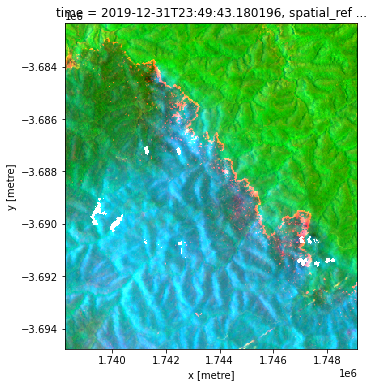

In [8]:
# Create a reusable query
query = {
    'x': xtuple, 
    'y': ytuple,
    'time': (hotspot_solar_day),
    'measurements': measurements,
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
try:
    ds = load_ard(dc=dc, products=sensors_products[sensor], min_gooddata=0.99, **query)
    rgb(ds, bands=[sensor_ignorance[sensor]['2.100-2.300'],sensor_ignorance[sensor]['0.845-0.885'],sensor_ignorance[sensor]['0.450-0.515']], index=0)
except:
    result = '-'


3.1. Daytime detection
The daytime algorithm uses input data from all seven OLI channels listed in Table 1.
The first test in the daytime module is designed to identify potentially unambiguous active fire pixels.
It builds on the ETM + active fire algorithm (Schroeder et al., 2008a) while accommodating small differences
in OLI spectral channels, and is based on the following condition:
1. {ratio between b7 b5 > 2.5 AND b7 - b5 > 0.3 AND b7 > 0.5}



In [9]:
# potentially unambiguous active fire pixels
test1 = (((ds[sensor_ignorance[sensor]['2.100-2.300']] / ds[sensor_ignorance[sensor]['0.845-0.885']]) > 2.5) *
         ((ds[sensor_ignorance[sensor]['2.100-2.300']]  - ds[sensor_ignorance[sensor]['0.845-0.885']]) > 3000) *
         (ds[sensor_ignorance[sensor]['2.100-2.300']] > 5000))

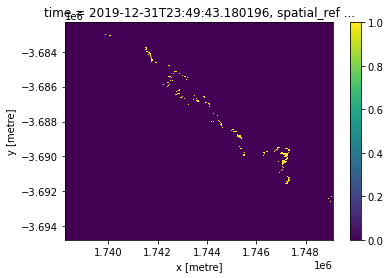

In [10]:
test1.plot()

* Highly energetic and extensive fires can lead to folding of the DN on channel 7 thereby characterizing another condition of potentially unambiguous active fire pixel. Those unique occurrences are flagged using:

    * 2. {b6 > 0.8 and b1 < 0.2 AND (b5 > 0.4 OR b7 < 0.1)}

In [11]:
# Unambiguous fire pixels
test2 = (((ds[sensor_ignorance[sensor]['1.560-1.660']] > 8000) *(ds[sensor_ignorance[sensor]['0.433-0.453']] < 2000)) * ((ds[sensor_ignorance[sensor]['0.845-0.885']] > 4000) + (ds[sensor_ignorance[sensor]['2.100-2.300']] < 1000)).clip(min=0, max=1))

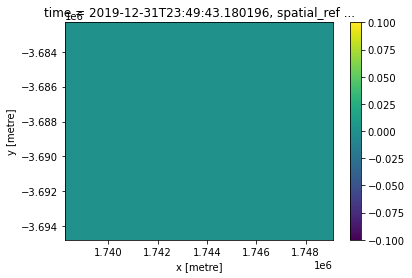

In [12]:
test2.plot()

* Complementing the identification of unambiguous fire pixels, the thresholds in test (1) are relaxed and other candidate fire pixels are selected for further analyses based on the following criteria:
    * 3. {ratio between b7 b5 > 1.8 AND b7-b5 > 0.17}

In [13]:
# other candidate fire pixels
test3 = (((ds[sensor_ignorance[sensor]['2.100-2.300']]/ds[sensor_ignorance[sensor]['0.845-0.885']]) > 1.8)* (ds[sensor_ignorance[sensor]['2.100-2.300']]-ds[sensor_ignorance[sensor]['0.845-0.885']]  > 1700))

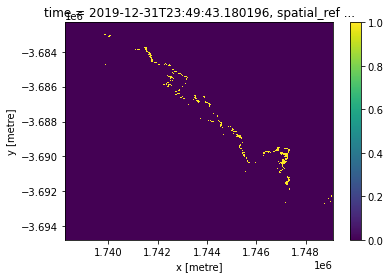

In [14]:
test3.clip(min=0, max=1).plot()

In [15]:
candidates = (test1 + test2 + test3).clip(min=0, max=1)

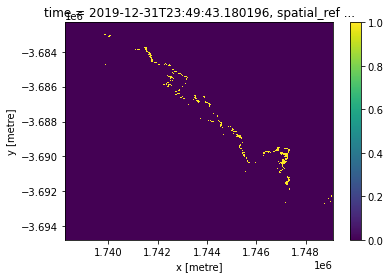

In [16]:
candidates.plot()

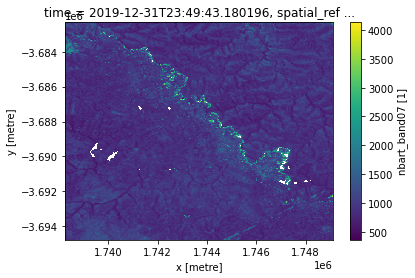

In [17]:
ds[sensor_ignorance[sensor]['2.100-2.300']].where(candidates.data == 0).plot()

In [18]:
mb7 = ds[sensor_ignorance[sensor]['2.100-2.300']].where(candidates.data == 0)
#mb5 = ds[sensor_ignorance[sensor]['0.845-0.885']].where(candidates.data == 0)
mb5 = np.ma.masked_where(candidates.data == 1, ds[sensor_ignorance[sensor]['0.845-0.885']]) 

In [19]:
np.nanmax(mb7.data)

4134.0

In [20]:
ds[sensor_ignorance[sensor]['2.100-2.300']].shape

(1, 415, 362)

In [21]:
t, x, y = candidates.data.shape

In [22]:
def get_context_kernel_array(x, y, array):
    #array example ds.nbart_band07.data
    # x is array x position
    # y is array y position
    
    T, X, Y = array.shape

    xmin = x - 60
    xmax = x + 60
    ymin = y - 60
    ymax = y + 60

    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0

    if xmax > X:
        xmax = X
    if ymax > Y:
        ymax = Y
    try:
        outarray = array[:, xmin:xmax][:, ymin:ymax]
    except:
        outarray = np.nans((61,61), dtype=np.float64)
    return(array[:, xmin:xmax][:, ymin:ymax])

In [23]:
# Find the candidates and perform context check
# TODO create mask that is ref7 > 0, non water and not other candidates
# mask
# b7=<0
# water
# othercandidates

indices = np.where(candidates.data == 1)

# band7 and band5 
test4= candidates
index = 0
for x in indices[1]:
    y = indices[2][index]
    #4. ratio between b7 b5 > ratio b7 b5 + max[3x std ratio b7 and b5, 0.8 ]
    #AND
    #5. b7 > b7 + max[3x std b7, 0.08]
    #AND
       
    kernelb7 = get_context_kernel_array(x,y,mb7.data)
    kernelb5 = get_context_kernel_array(x,y,mb5.data)
    
    test4.data[0][x][y] = ((ds[sensor_ignorance[sensor]['2.100-2.300']].data[0][x][y]/ds[sensor_ignorance[sensor]['0.845-0.885']].data[0][x][y]) > np.nanmean(kernelb7/kernelb5) + max(3*np.nanstd(kernelb7/kernelb5), 0.8)) 
    print(candidates.data[0][x][y],(ds[sensor_ignorance[sensor]['2.100-2.300']].data[0][x][y]/ds[sensor_ignorance[sensor]['0.845-0.885']].data[0][x][y]), np.nanmean(kernelb7/kernelb5) + max(3*np.nanstd(kernelb7/kernelb5), 0.8) )
    #print(test4)
    # Write values to new dimension
    
    index = index + 1

1 2.1575162 1.3463903546333313
1 4.555813 1.3463903546333313
1 2.1575162 1.3465000867843628
1 4.5469837 1.3465000867843628
1 2.21197 1.3465764403343201
1 2.1665647 1.3467012524604798
1 3.5399399 1.3467012524604798
1 4.335928 1.3465688705444336
1 3.097954 1.3468623042106629
1 2.871299 1.3468623042106629
1 2.4111178 1.3554694533348084
1 2.1772778 1.3674286484718323
1 2.0325496 1.3677508115768433
1 3.4137115 1.3680299997329712
1 5.1963263 1.3680463314056397
1 3.9375 1.3673823356628418
1 2.3977764 1.367735493183136
1 5.1963263 1.368358302116394
1 2.8783216 1.368543791770935
1 3.3872762 1.368568229675293
1 2.309389 1.3634136199951172
1 3.212778 1.3659103989601136
1 3.7394905 1.3664150714874268
1 3.9297857 1.3687151551246644
1 4.0529532 1.3687419772148133
1 2.1028214 1.3628064274787903
1 2.5382469 1.3640080571174622
1 2.4848309 1.3645408630371094
1 2.3885467 1.365068542957306
1 6.3340645 1.3687991380691529
1 4.3601637 1.3688268542289734
1 2.2079082 1.3607070922851563
1 3.4057796 1.3611186623

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


1 4.388478 1.32806293964386
1 2.3905966 1.3388660430908204
0 3.3566687 nan
0 3.3326004 nan
1 4.7581735 1.328622329235077
0 3.3326004 nan
1 4.1035504 1.3297533869743348
1 4.4858756 1.3290745496749878
1 1.9534993 1.328653919696808
1 2.4042807 1.3414484143257142
1 2.3828728 1.3434578061103821
0 3.6374724 nan
1 3.3430178 1.3289793610572815
1 2.5113225 1.3285727977752686
1 5.1608596 1.3395387411117554
1 3.408421 1.3353721976280213
0 2.1050148 nan
1 2.3497221 1.3269578099250794
1 4.346763 1.326574730873108
1 2.7635212 1.3325362086296082
1 4.6456733 1.3267086625099183
1 3.2122858 1.326680588722229
1 3.8259127 1.3263067483901978
1 1.852189 1.3267696976661683
1 4.2369266 1.334203052520752
1 5.479452 1.3304431319236756
1 2.5055387 1.3313897132873536
1 2.8497255 1.3274125933647156
0 2.6683145 nan
1 3.3453557 1.3235834121704102
0 4.844961 nan
0 1.9027277 nan
0 2.848276 nan
0 2.121858 nan
0 2.2416947 nan
0 4.8060975 nan
0 4.638348 nan
0 4.6844287 nan
0 2.1465347 nan
0 1.9951291 nan
0 4.971178 nan
0

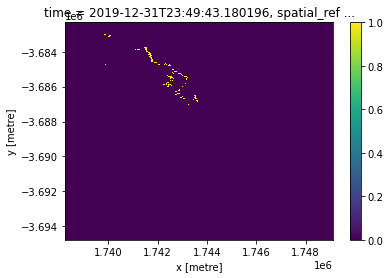

In [24]:
test4.plot()

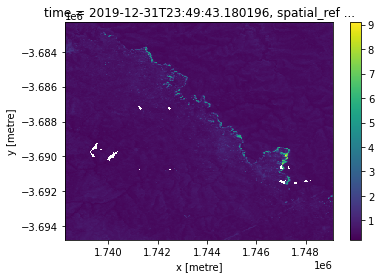

In [25]:
(ds[sensor_ignorance[sensor]['2.100-2.300']]/ds[sensor_ignorance[sensor]['0.845-0.885']]).plot()

All pixels satisfying test (3) must then meet the following set of fixed threshold and contextual tests in order
to be classified as potential fire-affected pixels:

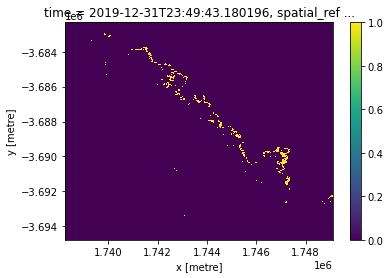

In [26]:
#6. ratio b7 b6 > 1.6
test6 = (ds.nbart_band07/ds.nbart_band06 > 1.6)
test6.clip(min=0, max=1).plot()

In [27]:


where 
¯
 and sRij (
¯
 and s?7) are the mean and standard deviation calculated for the band ratio (channel 7 reflectance) using valid
background pixels from a 61 × 61 window centered on the candidate pixel. 
Valid pixels are defined as those showing channel 7 reflectance greater than zero, excluding water and 
unambiguous fire pixels. Water pixels are classified based on spectral profiling using reflectance data 
from all seven input channels. Two distinct tests are applied in order to map oceans and inland water bodies
according to: 


SyntaxError: invalid character in identifier (<ipython-input-27-6e69ffe322d6>, line 2)

In [28]:
# Oceans test
#7. {b4 > b5 AND b5 > b6 AND b6 > b7 AND b1 - b7 < 0.2}
test7 = ((ds.nbart_band04 > ds.nbart_band05) *
          (ds.nbart_band05 > ds.nbart_band06) *
          (ds.nbart_band06 > ds.nbart_band07))# *
          ((ds.nbart_band01 - ds.nbart_band07) < 0.2))
test7.clip(min=0, max=1).plot()


IndentationError: unexpected indent (<ipython-input-28-1c25ae0dd5dd>, line 6)

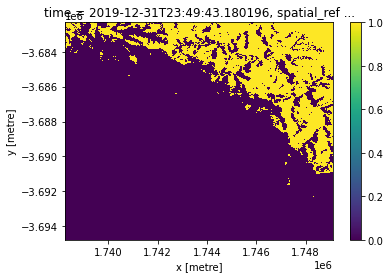

In [477]:
# Water bodies test - comment - seems like  bad test / smoke complications?
#AND
#8. {(b3 > b2)
test8 = (ds.nbart_band03 > ds.nbart_band02)
test8.clip(min=0, max=1).plot()


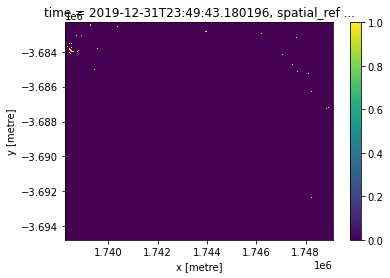

In [478]:
#OR
#9. (b1 > b2 AND b2 > b3 AND b3 < b4)}.
test9 = ((ds.nbart_band01 > ds.nbart_band02) *(ds.nbart_band02 > ds.nbart_band03) * (ds.nbart_band03 < ds.nbart_band04))
test9.clip(min=0, max=1).plot()